In [339]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy.fft as fft

In [340]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(device)

cpu


In [341]:
num_frames = 100

num_alphas = 10
alphlowlim = 0.0
alphhighlim = 0.9
num_ds = 50
dlowlim = 0.0
dhighlim = 4.9

In [342]:
alpha_vals = np.linspace(alphlowlim, alphhighlim, num_alphas)
print(alpha_vals)
alpha_vals[0] = 1e-10 # set alpha=0 to a small value

d_vals = np.linspace(dlowlim, dhighlim, num_ds)
print(d_vals)
d_vals[0] = 1e-10 # set d=0 to a small value


r_vals = np.linspace(0.0, 10.0, 501)
r_vals = r_vals[:-1]
r_vals[0] = 1e-10 # set r=0 to a small value

k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])
k_vals = fft.fftshift(k_vals)

# convert to tensor
r_vals = torch.from_numpy(r_vals).float().to(device)


# print the shape of the data
print(f"shape of alpha_vals : {alpha_vals.shape}")
print(f"shape of d_vals : {d_vals.shape}")

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9]
shape of alpha_vals : (10,)
shape of d_vals : (50,)


In [343]:
# initial guess for P_alpha_d
P_alpha_d = np.zeros((num_frames, num_alphas, num_ds))
# for i in range(num_frames):
#     P_alpha_d[i, 0, 0] = 1.0


alpha0 = 0.7
d0 = 1.0
for i in range(num_alphas):
    for j in range(num_ds):
        P_alpha_d[:, i, j] = np.exp(-((alpha_vals[i] - alpha0)**2 + (d_vals[j] - d0)**2) / 0.1)

# # normalize P_alpha_d
P_alpha_d = P_alpha_d / np.trapz(np.trapz(P_alpha_d, x=d_vals, axis=2), x=alpha_vals, axis=1)[:, None, None]
# P_alpha_d = P_alpha_d / np.sum(P_alpha_d, axis=(1, 2))[:, None, None]


# convert to tensor
alpha_vals = torch.from_numpy(alpha_vals).float().to(device)
# convert to tensor
d_vals = torch.from_numpy(d_vals).float().to(device)
# convert to tensor
k_vals = torch.from_numpy(k_vals).float().to(device)

# convert P_alpha_d to torch tensor
P_alpha_d = torch.tensor(P_alpha_d, dtype=torch.float32, device=device, requires_grad=True)
# restrict P_alpha_d to be positive while training
# P_alpha_d = torch.clamp(P_alpha_d, min=0.0)
# print(P_alpha_d)

In [344]:
def contour_plt(P_alpha_d, i=0):
    """
    Visualise P_alpha_d as a countour plot using contourf
    """
    # plot
    # rescale the y axis to be in the range of 0 to 2
    # rescale the x axis to be in the range of 0 to 1000
    # check if P_alpha_d is a torch tensor
    if isinstance(P_alpha_d, torch.Tensor):
        P_alpha_d_copy = P_alpha_d.detach().cpu().numpy()
    else:
        P_alpha_d_copy = P_alpha_d.copy()
    plt.figure(figsize=(4, 4))
    x = np.linspace(dlowlim, dhighlim, num_ds)
    y = np.linspace(alphlowlim, alphhighlim, num_alphas)
    plt.contourf(x, y, P_alpha_d_copy[i], 20, cmap='RdGy')
    plt.xlabel('d')
    plt.ylabel('alpha')
    plt.colorbar()
    plt.show()

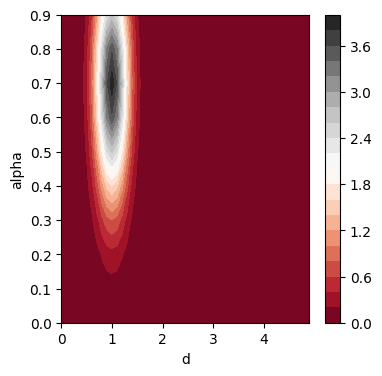

In [345]:
# # visualize P_alpha_d inital in subplots
# for i in range(num_frames):
#     contour_plt(P_alpha_d, i)
contour_plt(P_alpha_d, 50)

In [346]:
# load u_pred
u = np.loadtxt("u.txt")
print(f"shape of u : {u.shape}")
# print(u_pred)
# convert to torch tensor
u = torch.tensor(u, dtype=torch.float32, device=device)
print(f"shape of u : {u.shape}")

shape of u : (100, 500)
shape of u : torch.Size([100, 500])


In [347]:
# load Z
Z = np.load("Z.npy")
print(f"shape of Z : {Z.shape}")
# convert Z to torch tensor
Z = torch.from_numpy(Z).float().to(device)
# print shape of Z
print(f"shape of Z : {Z.shape}")
# print(Z)
# normalize Z to have integral of Z over r equal to 1
# Z = Z / np.sum(Z * (r_vals[1]-r_vals[0]))
# print(Z)

shape of Z : (10, 50, 100, 500)
shape of Z : torch.Size([10, 50, 100, 500])


In [348]:
def give_u_pred(P_alpha_d, Z, alpha_vals, d_vals):
    """
    Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
    """
    # initialize u_pred
    u_pred = torch.zeros((num_frames, len(r_vals)))
    # move u_pred to device
    u_pred = u_pred.to(device)

    for i in range(u_pred.shape[0]):
        for j in range(u_pred.shape[1]):
            integrand = torch.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals)
            u_pred[i, j] = torch.trapz(integrand, alpha_vals)

    # normalize u_pred
    # u_pred = u_pred / (u_pred.sum(dim=1, keepdim=True) + 1e-9)
    # u_pred = u_pred / (torch.trapz(u_pred, k_vals, dim=1, keepdim=True) + 1e-9)
    
    # norm = (torch.trapz(u_pred, k_vals, dim=1))

    # u_pred = u_pred / norm[:, None]


    return u_pred    

In [349]:
# manual loss function
def loss_function(P_alpha_d, u, Z, alpha_vals, d_vals):
    # clamp P_alpha_d to be positive
    # P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)
    # normalize P_alpha_d
    norm = (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1))
    P_alpha_d = P_alpha_d / norm[:, None, None]
    # P_alpha_d = P_alpha_d / (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1, keepdim=True) + 1e-6)
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True))
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True) + 1e-6)
    # calculate u_pred using double integral
    u_pred = give_u_pred(P_alpha_d, Z, alpha_vals, d_vals)
    # calculate loss
    loss = torch.sum((u_pred - u)**2)
    # loss /= u.shape[0] * u.shape[1]
    # loss = torch.sum(abs(u_pred - u))

    return loss

In [350]:
# write a function to train the model
def train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=100, lr=1e-1):
    # define the optimizer
    optimizer = torch.optim.Adam([P_alpha_d], lr=lr)
    # define the loss function
    loss_func = loss_function
    # define the loss history
    loss_history = []
    # train the model
    for epoch in range(num_epochs):
        # calculate loss
        loss = loss_func(P_alpha_d, u, Z, alpha_vals, d_vals)
        # zero the gradients
        optimizer.zero_grad()
        # backpropagate
        loss.backward()
        # update parameters
        optimizer.step()
        # append loss to loss history
        loss_history.append(loss.item())
        P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)

        # plot P_alpha_d
        if (epoch+1) % 5 == 0:
            contour_plt(P_alpha_d, 50)
        # print loss
        if (epoch+1) % 1 == 0:
            print(f"epoch {epoch+1} / {num_epochs} : loss = {loss.item()}")
    # plot loss history
    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    return P_alpha_d

epoch 1 / 500 : loss = 221.56744384765625
epoch 2 / 500 : loss = 212.00587463378906
epoch 3 / 500 : loss = 205.810546875
epoch 4 / 500 : loss = 201.04428100585938


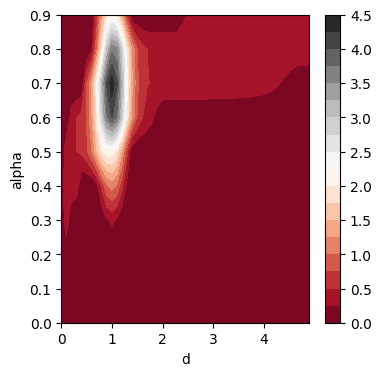

epoch 5 / 500 : loss = 197.51148986816406
epoch 6 / 500 : loss = 194.5007781982422
epoch 7 / 500 : loss = 191.99581909179688
epoch 8 / 500 : loss = 189.8719482421875
epoch 9 / 500 : loss = 188.10574340820312


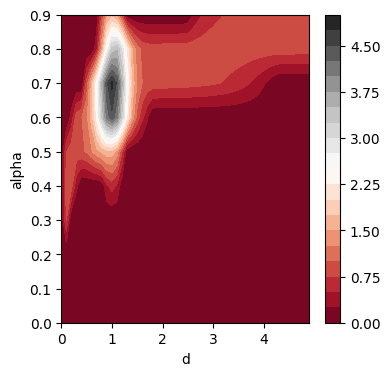

epoch 10 / 500 : loss = 186.5821990966797
epoch 11 / 500 : loss = 185.17391967773438
epoch 12 / 500 : loss = 183.88775634765625
epoch 13 / 500 : loss = 182.83425903320312
epoch 14 / 500 : loss = 181.8463134765625


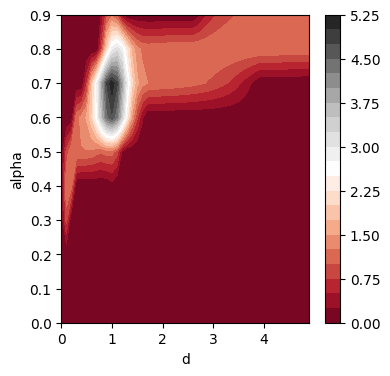

epoch 15 / 500 : loss = 180.90750122070312
epoch 16 / 500 : loss = 180.0396728515625
epoch 17 / 500 : loss = 179.2783966064453
epoch 18 / 500 : loss = 178.57278442382812
epoch 19 / 500 : loss = 177.92575073242188


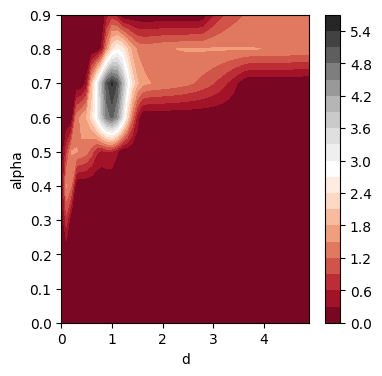

epoch 20 / 500 : loss = 177.3689727783203
epoch 21 / 500 : loss = 176.85525512695312
epoch 22 / 500 : loss = 176.36395263671875
epoch 23 / 500 : loss = 175.8865203857422
epoch 24 / 500 : loss = 175.42120361328125


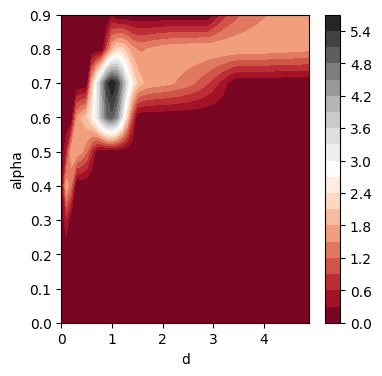

epoch 25 / 500 : loss = 174.97914123535156
epoch 26 / 500 : loss = 174.59799194335938
epoch 27 / 500 : loss = 174.26260375976562
epoch 28 / 500 : loss = 173.9638214111328
epoch 29 / 500 : loss = 173.70693969726562


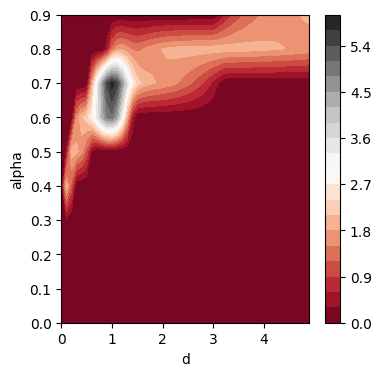

epoch 30 / 500 : loss = 173.46920776367188
epoch 31 / 500 : loss = 173.24447631835938
epoch 32 / 500 : loss = 173.03082275390625
epoch 33 / 500 : loss = 172.82647705078125
epoch 34 / 500 : loss = 172.6341094970703


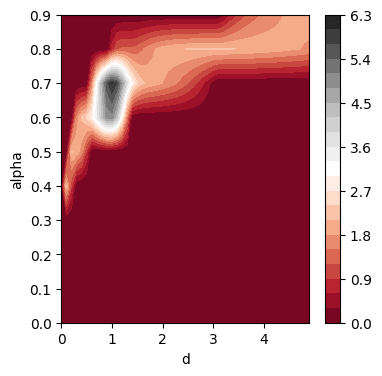

epoch 35 / 500 : loss = 172.45111083984375
epoch 36 / 500 : loss = 172.27725219726562
epoch 37 / 500 : loss = 172.11444091796875
epoch 38 / 500 : loss = 171.9607696533203
epoch 39 / 500 : loss = 171.81495666503906


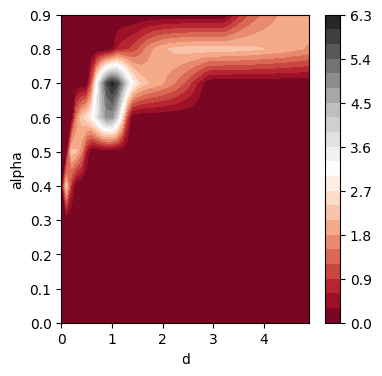

epoch 40 / 500 : loss = 171.67636108398438
epoch 41 / 500 : loss = 171.54364013671875


KeyboardInterrupt: 

In [351]:
# train the model
P_alpha_d = train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=500, lr=1e-1)

In [ ]:
P_alpha_d_cpu = P_alpha_d.cpu().detach().numpy()
# normalize P_alpha_d_cpu
# P_alpha_d_cpu = P_alpha_d_cpu / (P_alpha_d_cpu.sum(axis=(1,2), keepdims=True))
print(f"shape of P_alpha_d_cpu : {P_alpha_d_cpu.shape}")
# save P_alpha_d_cpu
np.save("P_alpha_d_cpu.npy", P_alpha_d_cpu)

shape of P_alpha_d_cpu : (100, 10, 50)


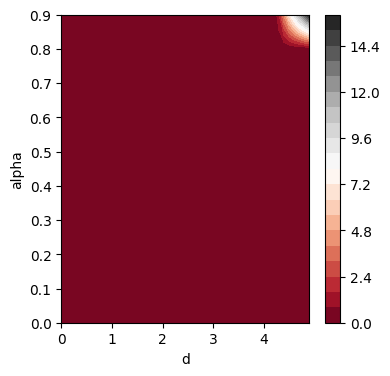

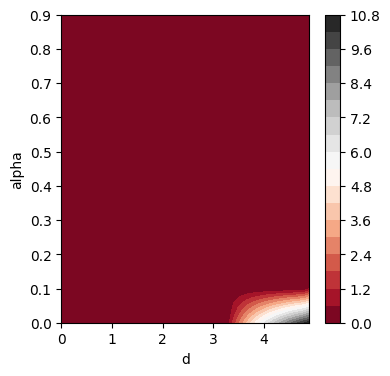

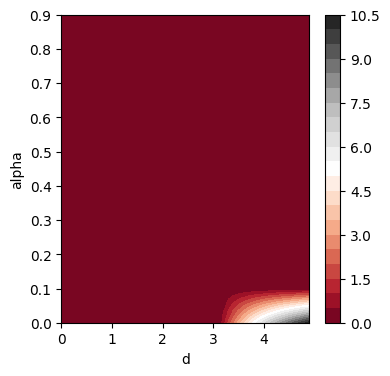

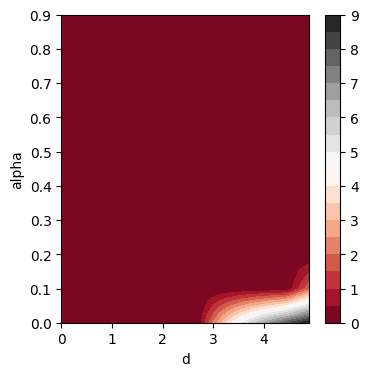

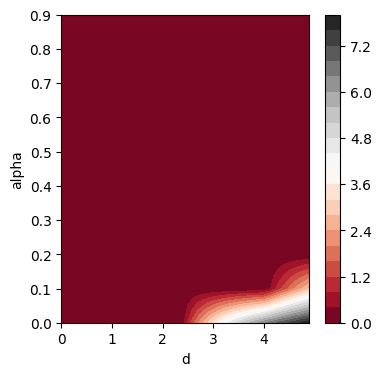

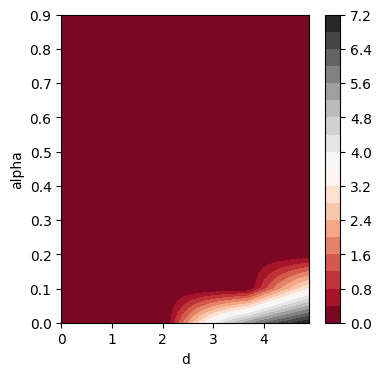

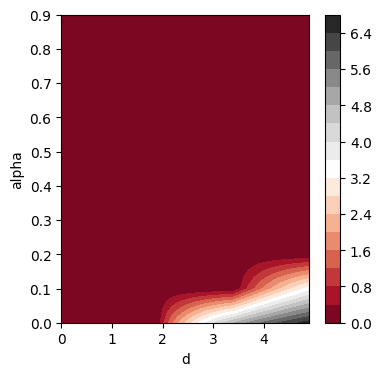

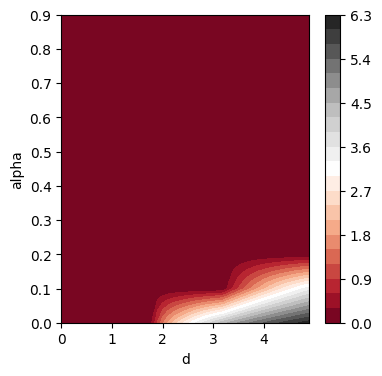

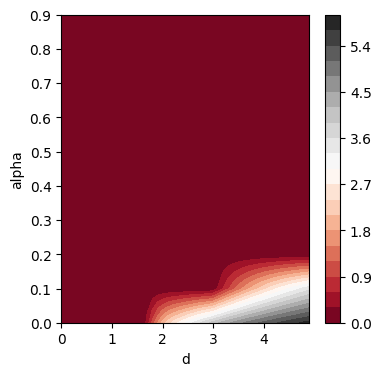

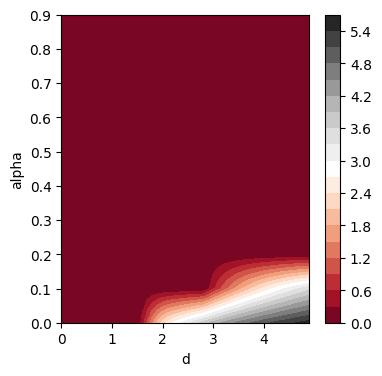

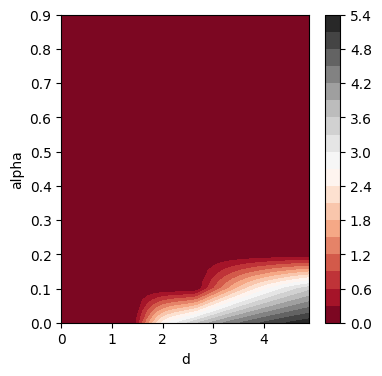

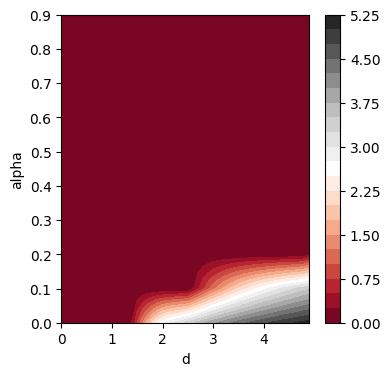

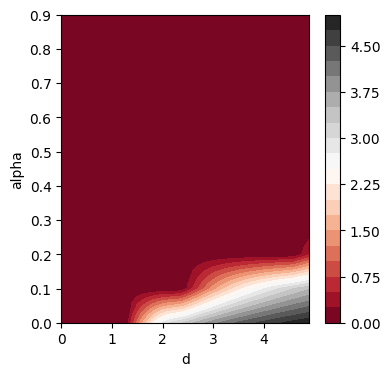

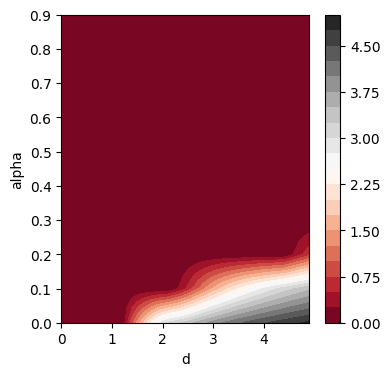

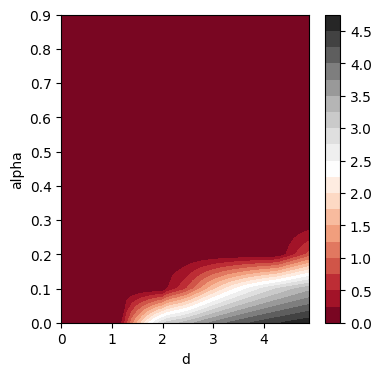

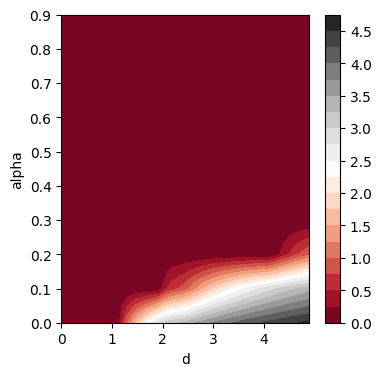

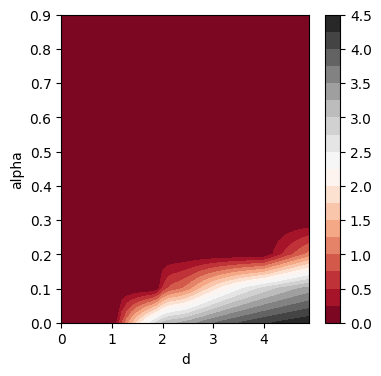

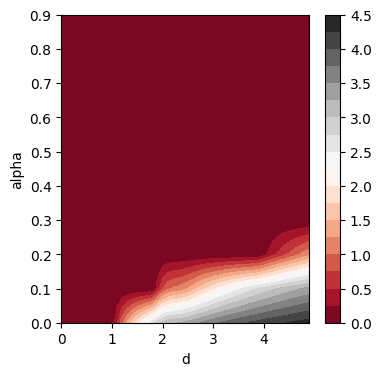

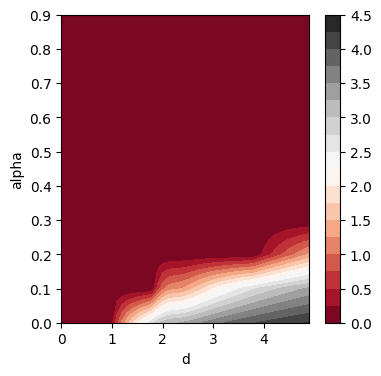

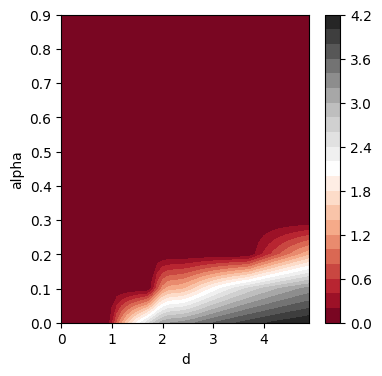

In [ ]:
for i in range(0, num_frames, 5):
    # copy P_alpha_d to cpu
    contour_plt(P_alpha_d_cpu, i)

In [ ]:
def give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals):
    """
    Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
    """
    # initialize u_pred
    u_pred = np.zeros((num_frames, len(r_vals)))

    # convert P_alpha_d to numpy array
    P_alpha_d = P_alpha_d.cpu().detach().numpy()
    Z = Z.cpu().detach().numpy()
    alpha_vals = alpha_vals.cpu().detach().numpy()
    d_vals = d_vals.cpu().detach().numpy()

    for i in range(u_pred.shape[0]):
        for j in range(u_pred.shape[1]):
            integrand = np.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals, axis=1)
            u_pred[i, j] = np.trapz(integrand, alpha_vals)

    # normalize u_pred
    u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True) + 1e-6)
    # u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True))

    # s_vals = np.linspace(0.0, 2*np.pi, 101)
    s_vals = np.linspace(0.0, 10, 101)
    s_vals[0] = 1e-10
    s_vals = s_vals[:-1]

    # get the range of k values
    # convert r_vals to numpy array
    r_vals = r_vals.cpu().detach().numpy()
    k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])
    k_vals = fft.fftshift(k_vals)
    # k_vals = 2 * np.pi * k_vals
    # print(k_vals)
    print(f"shape of k_vals : {k_vals.shape}")

    # visualize u_pred
    plt.figure(figsize=(10, 8))
    plt.title("u_pred(s, k) for some s values")
    plt.xlabel("k")
    plt.ylabel("u_pred(s, k)")
    plt.grid()
    for i in range(0, s_vals.shape[0], 10):
        if i == 0:
            continue
        plt.plot(k_vals, u_pred[i, :], label=f"s = {s_vals[i]:.2f}")

    plt.legend()
    plt.show()

shape of k_vals : (500,)


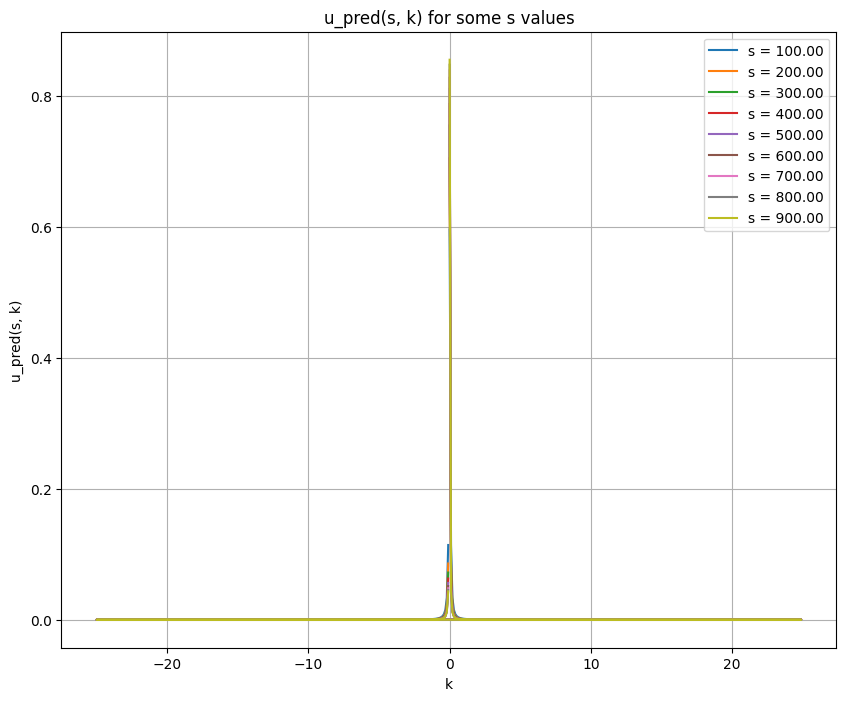

In [ ]:
# reproduce u_pred
give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals)
